## 1. About Author

- `Name`: Ahmad Mubarak
- `Code Submission Date`: 
- `Project`: Brain Tumor Detection
- `Authors Contact info`:
  - [Email](ahmadmubarak01@gmail.com)
  - [LinkedIn](https://www.linkedin.com/in/ahmad-mubarak-19861a177/)
  - [Github](https://github.com/Ahmad1998-RPA)

## 1.1 Meta Data (About the Data)

- `Data`: Brain Tumor Detection
- `Dataset`: [link](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data)
- `Description`: The Data set was downloaded from kaggle.

  I have downloaded this dataset from kaggle for practice. Using pretrained model `VGG16`, used `Transfer Learning` technique, in which i have trained the model on MRI Training images dataset. This Data contains two main folders `Testing` and `Training`. Having 4 subfolders, `glioma`, `meningioma`, `notumor` and `pituitary` in both main folders.

## 1.2 Kernel Version Used.

- `Python 3.10.3`

## 2. Importing Libraries

In [1]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model

## 3. Load Dataset

In [2]:
train_dir = 'E:/DataScience/BrainTumorDetection/MRI Images/Training/'
test_dir = "E:/DataScience/BrainTumorDetection/MRI Images/Testing/"

# load and shuffle the train data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for img in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, img))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# load and shuffle the test data
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for img in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, img))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

## 4. Data visualization

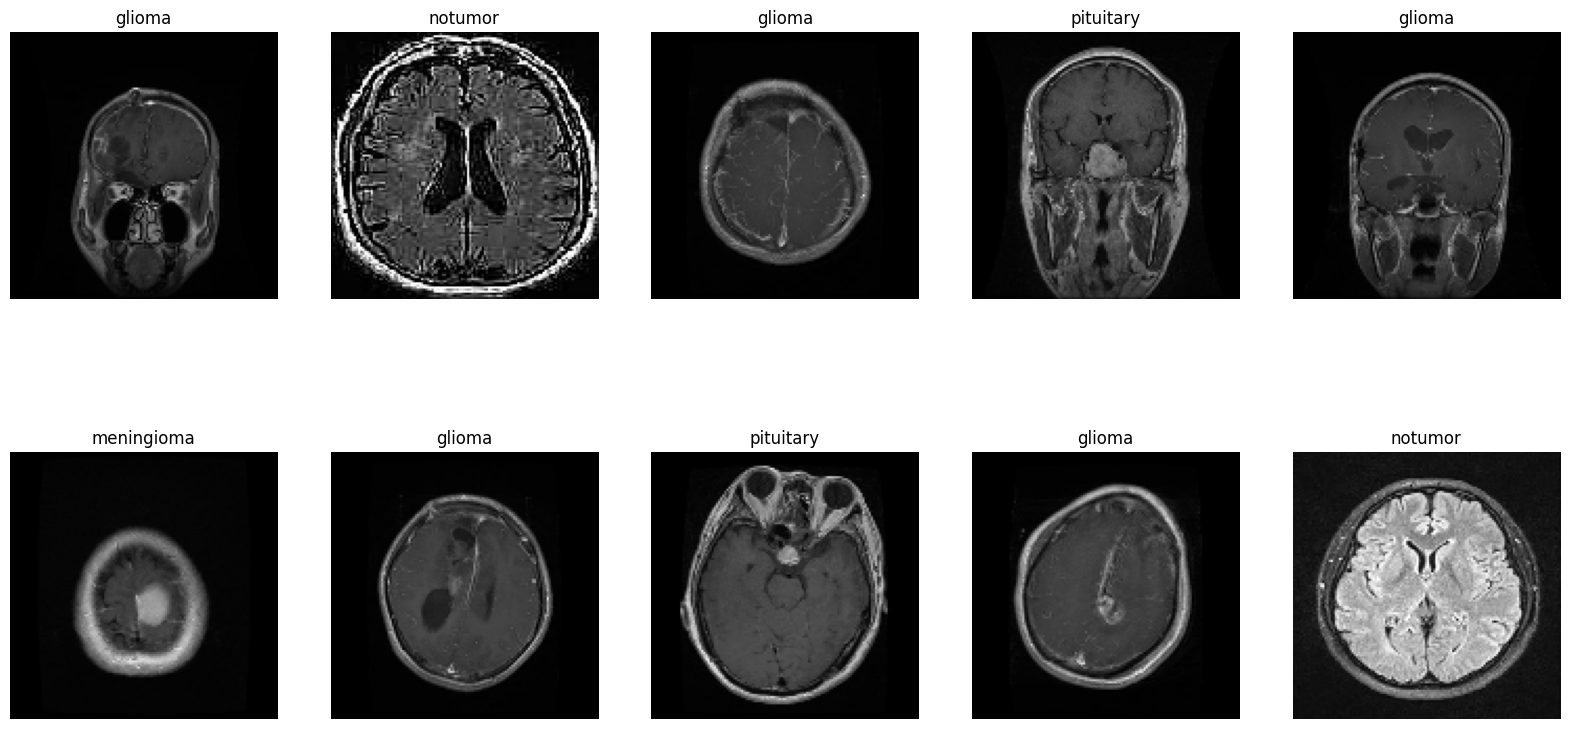

In [3]:
# lets select 10 random images from the training set
random_indices = random.sample(range(len(train_paths)), 10)
random_images = [train_paths[i] for i in random_indices]
random_labels = [train_labels[i] for i in random_indices]
# lets visualize the images
plt.figure(figsize=(20, 10))
for i, img_path in enumerate(random_images):
    plt.subplot(2, 5, i + 1)
    img = load_img(img_path, target_size=(128, 128))
    plt.imshow(img)
    plt.title(random_labels[i])
    plt.axis('off')
plt.show()

## 5. Image Preprocessing

In [4]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image) / 255.0
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(128, 128))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels
def encode_label(labels):
    unique_labels = os.listdir(train_dir)
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

## 6. Mode Training

In [5]:
# Model architecture
IMAGE_SIZE = 128
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)
epochs = 10

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
285/285 [==============================] - 360s 1s/step - loss: 0.4606 - sparse_categorical_accuracy: 0.8263
Epoch 2/10
285/285 [==============================] - 338s 1s/step - loss: 0.2308 - sparse_categorical_accuracy: 0.9158
Epoch 3/10
285/285 [==============================] - 338s 1s/step - loss: 0.1572 - sparse_categorical_accuracy: 0.9415
Epoch 4/10
285/285 [==============================] - 338s 1s/step - loss: 0.1136 - sparse_categorical_accuracy: 0.9570
Epoch 5/10
285/285 [==============================] - 336s 1s/step - loss: 0.0918 - sparse_categorical_accuracy: 0.9664
Epoch 6/10
285/285 [==============================] - 337s 1s/step - loss: 0.0544 - sparse_categorical_accuracy: 0.9780
Epoch 7/10
285/285 [==============================] - 336s 1s/step - loss: 0.0640 - sparse_categorical_accuracy: 0.9743
Epoch 8/10
285/285 [==============================] - 390s 1s/step - loss: 0.0368 - sparse_categorical_accuracy: 0.9877
Epoch 9/10
285/285 [====================

## 7. Model Accuracy & Loss Plot

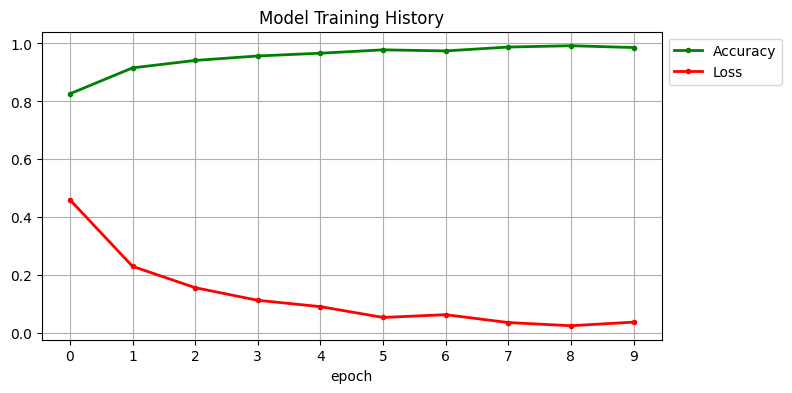

In [6]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## 8. Model Classification Report

In [ ]:
# Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 [==============================] - 59s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       300
           1       0.84      0.99      0.91       306
           2       0.99      1.00      0.99       405
           3       1.00      0.91      0.95       300

    accuracy                           0.95      1311
   macro avg       0.95      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311



## 9. Model Confusion Plot

Confusion Matrix:
[[258  39   3   0]
 [  2 303   1   0]
 [  0   1 404   0]
 [  8  17   1 274]]


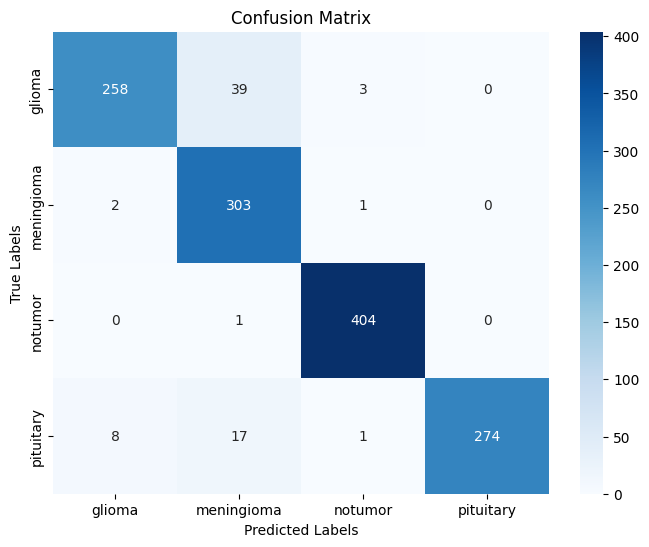

In [ ]:
# Let's plot Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## 10. Roc Curve Plot

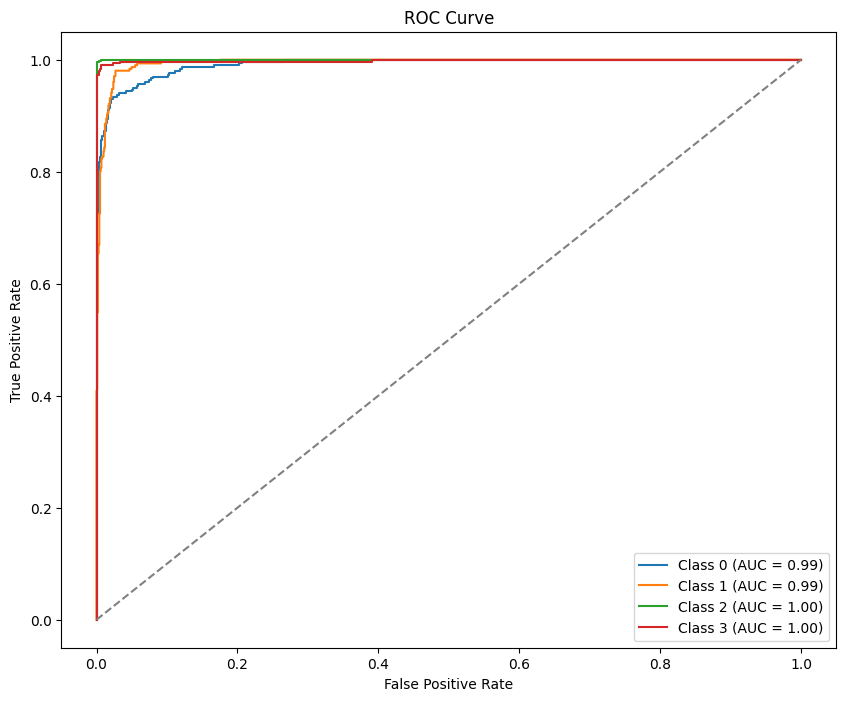

In [ ]:
# Let's plot the ROC curve
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # To set Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

## 11. Save & Load Model

In [10]:
# Save the entire model
model.save('models/btd_model_01.h5')

In [11]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('models/btd_model_01.h5')

## 12. MRI Tumor Detection System

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 [==============================] - 0s 123ms/step


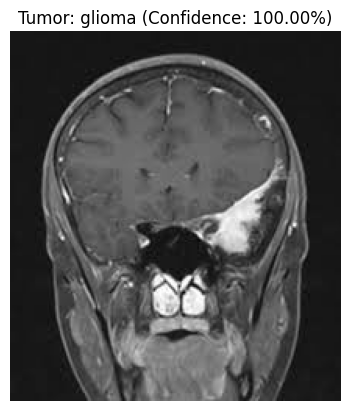

In [ ]:
image_path = 'E:\DataScience\BrainTumorDetection\MRI Images\Testing\meningioma\Te-meTr_0003.jpg'
detect_and_display(image_path, model)

1/1 [==============================] - 0s 153ms/step


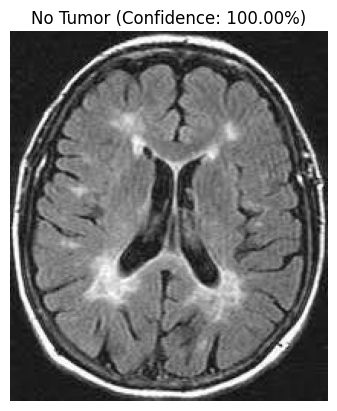

In [ ]:
image_path = 'E:/DataScience/BrainTumorDetection/MRI Images/Testing/notumor/Te-no_0115.jpg'
detect_and_display(image_path, model)

1/1 [==============================] - 0s 166ms/step


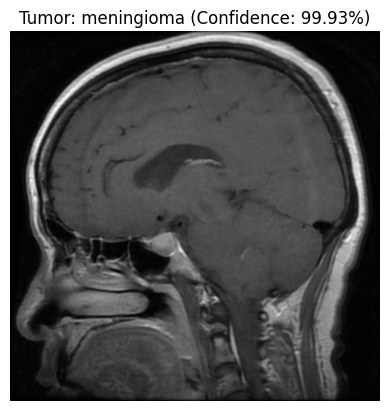

In [ ]:
image_path = 'E:\DataScience\BrainTumorDetection\MRI Images\Testing\pituitary\Te-piTr_0003.jpg'
detect_and_display(image_path, model)

1/1 [==============================] - 0s 113ms/step


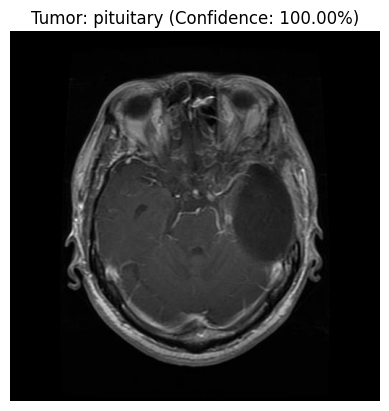

In [ ]:
image_path = 'E:\DataScience\BrainTumorDetection\MRI Images\Testing\glioma\Te-gl_0015.jpg'
detect_and_display(image_path, model)